# Archetype Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import load_iris

wine = load_iris()

X = wine.data
target = wine.target

In [3]:
from archetypes.sklearn import AA

method_kwargs = {
    "max_iter_optimizer": 10,
}

n_archetypes = 3

model = AA(n_archetypes=n_archetypes, method="pgd", method_kwargs=method_kwargs)
model.fit(X)

model.archetypes_

array([[4.96047149, 2.19765046, 3.89529813, 1.27670872],
       [7.56667904, 3.23128466, 6.6259116 , 2.32293832],
       [4.9024686 , 3.51670896, 1.105649  , 0.16317901]])

In [4]:
from archetypes.datasets import sort_by_archetype_similarity, permute_dataset

X_sorted, info = sort_by_archetype_similarity(X, [model.similarity_degree_], model.archetypes_)

similarity_degree_permuted, _ = permute_dataset(model.similarity_degree_, info["perms"])

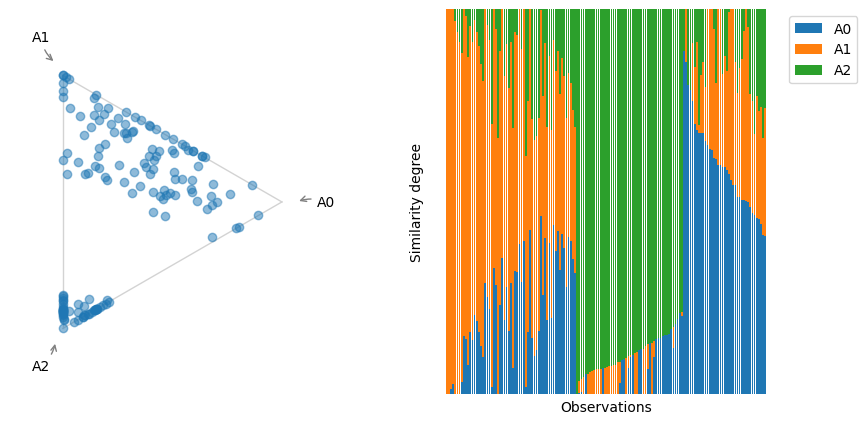

In [6]:
import matplotlib.pyplot as plt
from archetypes.visualization import stacked_bar, simplex

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
simplex(similarity_degree_permuted, alpha=0.5, ax=ax[0])
stacked_bar(similarity_degree_permuted, ax=ax[1])

plt.show()